In [181]:
import time
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sb

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

In [76]:
dbname = 'tutor_db'
username = 'codonnell'
pswd = '7883511'
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM tutor_main
LEFT JOIN zip_incomes ON tutor_main.zip_code = zip_incomes.zip_code
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours,index,zip_code,average_age,household_income,pop
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0.375000,0.375000,0.583333,0.583333,0.500000,NaN,NaN,NaN,NaN,NaN
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0.583333,0.583333,0.500000,0.333333,0.517857,NaN,NaN,NaN,NaN,NaN
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0.541667,0.250000,0.416667,0.375000,0.357143,NaN,NaN,NaN,NaN,NaN
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0.125000,0.125000,0.083333,0.000000,0.089286,NaN,NaN,NaN,NaN,NaN


In [10]:
with_incomes = tutor_data[~tutor_data['household_income'].isnull()]

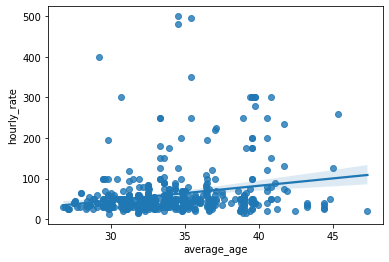

In [14]:
sb.regplot(with_incomes['average_age'],with_incomes['hourly_rate'])

In [23]:
sql_query = """
SELECT zip_code, SUM(num_tutors) AS tot_tutors
FROM tutor_nums
GROUP BY zip_code

"""
tutor_datanum = pd.read_sql_query(sql_query,con)
tutor_datanum.head()

,zip_code,tot_tutors
0,10456,3731.0
1,33467,300.0
2,60625,813.0
3,91706,730.0
4,91710,359.0


In [21]:
sql_query = """
WITH a AS (
SELECT zip_code, COUNT(num_tutors) AS tot_tutors
FROM tutor_nums
GROUP BY zip_code
)

SELECT * FROM tutor_main
LEFT JOIN tutor_nums ON tutor_main.zip_code = a.zip_code
"""
tutor_datanum = pd.read_sql_query(sql_query,con)
tutor_datanum.head()

DatabaseError: Execution failed on sql '
WITH a AS (
SELECT zip_code, COUNT(num_tutors) AS tot_tutors
FROM tutor_nums
GROUP BY zip_code
)

SELECT * FROM tutor_main
LEFT JOIN tutor_nums ON tutor_main.zip_code = a.zip_code
': missing FROM-clause entry for table "a"
LINE 9: LEFT JOIN tutor_nums ON tutor_main.zip_code = a.zip_code
                                                      ^


In [53]:
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])
tutor_data['log_bio_length'] = np.log(tutor_data['bio_length'])

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance

In [54]:
cat_features = ['state']
num_features = ['background_check','photo','rating_count','rating_av','review_count','log_bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']

# Use simple label encoding
encoder = LabelEncoder()
encoded_data = tutor_data[num_features].join(tutor_data[cat_features].apply(encoder.fit_transform))

In [55]:
# Set up feature data and target data
X = encoded_data.drop('log_hourly_rate', axis=1).values
y = encoded_data['log_hourly_rate'].values

# Initialise a balanced logisitic regression model
model_base = XGBRegressor()

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

model_base.fit(train_X, train_y)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y), np.exp(preds_val))
print(mae)

21.125065647125243


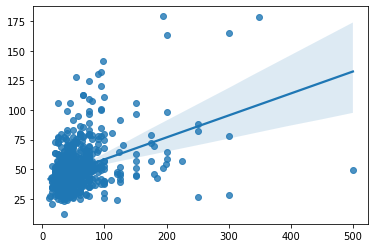

In [56]:
sb.regplot(np.exp(val_y),np.exp(preds_val))

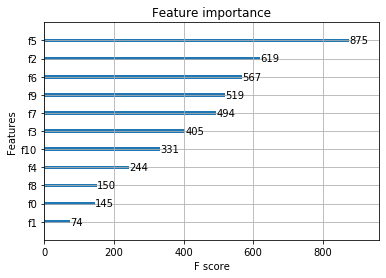

In [44]:
plot_importance(model_base)
plt.show()

In [57]:
sql_query = """

SELECT * FROM tutor_subjects

"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutor_subjects.head()

,index,tutor_ids,subjects
0,0,7269032,Precalculus
1,1,7269032,French
2,2,7269032,European History
3,3,7269032,Calculus
4,4,7269032,Spanish


In [60]:
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()

In [65]:
stopWords = []
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords
)
tfidf.fit(tutors_joined['subjects'])
text = tfidf.transform(tutors_joined['subjects'])

In [66]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

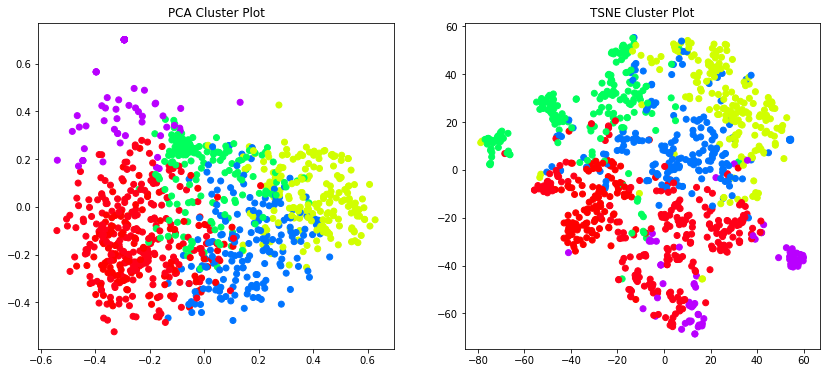

In [72]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=data.shape[0], replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    
    # choose only labels associated with subset of data 
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [74]:
tutors_joined['subject_cluster'] = clusters
tutors_joined.head()

,tutor_ids,subjects,subject_cluster
0,12202,Python Spelling Elementary Science Elementary ...,2
1,12351,Probability ACT Math Elementary Math GED Calcu...,1
2,13030,Spanish,4
3,13057,Special Needs ACT Reading ACT English ADHD Stu...,5
4,13967,SAT Math Praxis ISEE ACT Science ACT Math Dent...,3


In [81]:
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)

In [82]:
tutors_clustered = pd.merge(tutor_data, tutors_joined, left_on = 'tut_id', right_on = 'tutor_ids')
tutors_clustered.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,saturday_hours,mean_hours,index,zip_code,average_age,household_income,pop,tutor_ids,subjects,subject_cluster
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0.583333,0.500000,NaN,NaN,NaN,NaN,NaN,7269032,Precalculus French European History Calculus S...,0
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0.333333,0.517857,NaN,NaN,NaN,NaN,NaN,7277990,Microsoft Windows Elementary Math SAT Reading ...,2
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,7611743,COOP/HSPT Marketing Theater Career Development...,2
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0.375000,0.357143,NaN,NaN,NaN,NaN,NaN,7614535,College Counseling ACT English Art History ACT...,0
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0.000000,0.089286,NaN,NaN,NaN,NaN,NaN,8022035,ESL/ESOL Spanish Piano Reading Phonics,4


In [95]:
tutors_clustered['log_hourly_rate'] = np.log(tutors_clustered['hourly_rate'])

cat_features = ['state']
num_features = ['background_check','photo','rating_count','rating_av','review_count','bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours','subject_cluster','log_hourly_rate']

# Use simple label encoding
encoder = LabelEncoder()
encoded_data = tutors_clustered[num_features].join(tutors_clustered[cat_features].apply(encoder.fit_transform))

In [106]:
# Set up feature data and target data
X = encoded_data.drop('log_hourly_rate', axis=1).values
y = encoded_data['log_hourly_rate'].values

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=1)

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

model_base.fit(train_X, train_y)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y), np.exp(preds_val))
print(mae)

19.572715741475424


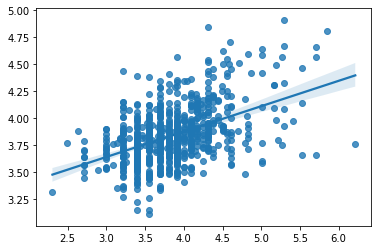

In [100]:
sb.regplot(val_y,preds_val)

In [110]:
tutor_data.groupby('qual_2')['hourly_rate'].mean()

qual_2
', '                   79.000000
']                     53.125000
EdD                    45.250000
Enrolled               47.469136
Graduate Coursework    52.943299
J.D.                   99.409836
MBA                    57.519084
MD                     49.708333
MEd                    53.771812
Masters                58.309937
Other                  46.286585
PhD                    73.242038
{}                     49.365282
Name: hourly_rate, dtype: float64

In [117]:
tutor_data['qual_1'].value_counts()

undergrad                         269
Mathematics                       164
English                           158
Physics                           129
{}                                125
                                 ... 
Geotechnical Engeerg, Master's      1
Studies                             1
Church Mistries                     1
Religion, Japanese                  1
BIOTECH                             1
Name: qual_1, Length: 1190, dtype: int64

In [114]:
tutor_data.groupby('qual_3')['hourly_rate'].mean()

qual_3
']                     50.000000
EdD                    57.095238
Enrolled               57.389831
Graduate Coursework    55.690265
J.D.                   93.187500
MBA                    76.108108
MD                     66.176471
MEd                    53.481481
Masters                62.880829
Other                  49.718182
PhD                    66.868421
{}                     52.946338
Name: hourly_rate, dtype: float64

In [116]:
tutor_data['qual_3'].value_counts()

{}                     2963
Masters                 193
PhD                     190
Graduate Coursework     113
Other                   110
Enrolled                 59
MBA                      37
MEd                      27
EdD                      21
MD                       17
J.D.                     16
']                        4
Name: qual_3, dtype: int64

In [123]:
def qual_encode(qual):
    
    qual_list = ['Masters','MBA','PhD','J.D.']
    qual_encodings = {'Masters': 1, 'MBA': 1, 'PhD': 2, 'J.D.': 3}
    if qual in qual_list:
        return qual_encodings[qual]
    else:
        return 0

In [129]:
tutors_clustered['qual_encoded'] = tutors_clustered.apply(lambda x: qual_encode(x['qual_1']) + qual_encode(x['qual_2']), axis =1) 

In [130]:
tutors_clustered.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,index,zip_code,average_age,household_income,pop,tutor_ids,subjects,subject_cluster,log_hourly_rate,qual_encoded
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,NaN,NaN,NaN,NaN,NaN,7269032,Precalculus French European History Calculus S...,0,4.094345,1
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,NaN,NaN,NaN,NaN,NaN,7277990,Microsoft Windows Elementary Math SAT Reading ...,2,4.317488,1
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,NaN,NaN,NaN,NaN,NaN,7611743,COOP/HSPT Marketing Theater Career Development...,2,4.553877,0
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,NaN,NaN,NaN,NaN,NaN,7614535,College Counseling ACT English Art History ACT...,0,4.553877,1
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,NaN,NaN,NaN,NaN,NaN,8022035,ESL/ESOL Spanish Piano Reading Phonics,4,4.828314,0


In [228]:
cat_features = ['state','qual_encoded']
#num_features = ['rating_count','rating_av','review_count','bio_length',
#               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']
all_features = ['state','qual_encoded', 'background_check',
               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']
#all_features = ['state','subject_cluster','qual_encoded', 'rating_count','rating_av','review_count','bio_length',
#               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']
tutors_cb = tutors_clustered[all_features]

# Use simple label encoding
cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)

In [229]:
# Set up feature data and target data
X = tutors_cb.drop('log_hourly_rate', axis=1)
y = tutors_cb['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=400, learning_rate=0.01, random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

20.189991744995115


In [233]:
import pickle

#filename = 'model_base.sav'
#pickle.dump(model_base, open(filename, 'wb'))
filename = 'model_base_data.pkl'
train_X.to_pickle("./model_base_data.pkl")

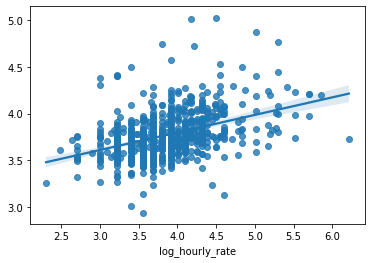

In [225]:
sb.regplot(val_y,preds_val)

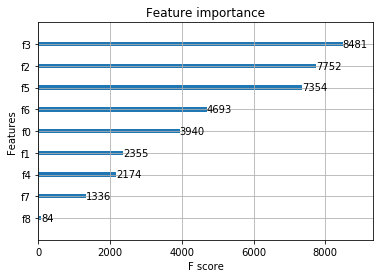

In [201]:
plot_importance(model_base)
plt.show()

In [182]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [186]:
# Set up feature data and target data
X = tutors_cb.drop('log_hourly_rate', axis=1)
y = tutors_cb['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

# Apply one-hot encoder to each column with categorical data
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[cat_features]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[cat_features]))

# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_X.drop(cat_features, axis=1)
num_X_valid = val_X.drop(cat_features, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


model_base.fit(OH_X_train.values, train_y.values)

preds_val = model_base.predict(OH_X_valid.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

20.638168230692543


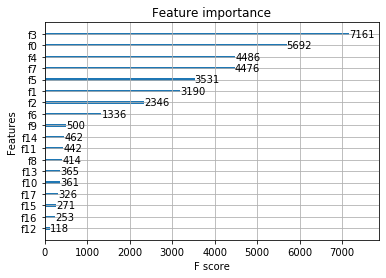

In [188]:
plot_importance(model_base)
plt.show()